<a href="https://colab.research.google.com/github/christine127/Portfolio_Recommendation_Project/blob/main/%EC%97%B0%EA%B4%80%EA%B7%9C%EC%B9%99_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import mlxtend
pd.options.display.float_format = '{:.6f}'.format

import warnings
warnings.filterwarnings('ignore')

from mlxtend.frequent_patterns import association_rules, fpgrowth
from itertools import combinations


In [4]:
path ='/content/drive/MyDrive/소회의실 프로젝트/전처리_완료/최종/'
file = pd.read_csv(path + '원본_210728.csv', encoding ='cp949')
customer_info = pd.read_csv(path+'customer_info_5가지_샘플제외.csv' )

sample_file = pd.read_csv(path+'원본_sample100.csv' , encoding='cp949')
sample_info = pd.read_csv(path+'customer_info_5가지_샘플.csv' )


In [5]:
# 거래횟수 상위 10 종목 제외

stock = file.groupby('상품명')['상품명'].count().sort_values(ascending = False)[:10]
stock= pd.DataFrame(stock).rename(columns = {'상품명':'count'}).reset_index()

file = file.loc[~file['상품명'].isin(stock['상품명'])]
sample_file = sample_file.loc[~sample_file['상품명'].isin(stock['상품명'])]

In [6]:

cluster_dict = customer_info.set_index('고객구분코드')['cluster'].to_dict()
file['cluster'] = file['고객구분코드'].map(cluster_dict).astype(str)

cluster_dict = sample_info.set_index('고객구분코드')['cluster'].to_dict()
sample_file['cluster'] = sample_file['고객구분코드'].map(cluster_dict).astype(str)

In [7]:
file['code'] = file['상품번호'].str[-6:]
sample_file['code'] = sample_file['상품번호'].str[-6:]


In [8]:
file= file.dropna()
customer_info =customer_info.dropna()
sample_info =sample_info.dropna()

In [9]:
# ## file
# retain_df = pd.DataFrame(file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
# retain_df['보유개수']= retain_df[('총체결수량',2)]-retain_df[('총체결수량',1)]
# retain_df['보유개수'] = np.where(retain_df['보유개수']<0, 0,retain_df['보유개수'])
# retain_stock_list = retain_df['보유개수'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
# customer_info.set_index('고객구분코드', inplace= True )
# customer_info = customer_info.join(retain_stock_list, how = 'left')

# ##sample_file
# retain_df_sample = pd.DataFrame(sample_file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
# retain_df_sample['보유개수']= retain_df_sample[('총체결수량',2)]-retain_df_sample[('총체결수량',1)]
# retain_df_sample['보유개수'] = np.where(retain_df_sample['보유개수']<0, 0,retain_df_sample['보유개수'])
# retain_stock_list_sample = retain_df_sample['보유개수'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
# sample_info.set_index('고객구분코드', inplace= True )
# sample_info = sample_info.join(retain_stock_list_sample, how = 'left')


In [10]:
## file
retain_df = pd.DataFrame(file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df['매수수량']= retain_df[('총체결수량',2)]
retain_stock_list = retain_df['매수수량'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
customer_info.set_index('고객구분코드', inplace= True )
customer_info = customer_info.join(retain_stock_list, how = 'left')

##sample_file
retain_df_sample = pd.DataFrame(sample_file.groupby(['고객구분코드','상품명','매도매수구분코드'])['총체결수량'].sum()).unstack('매도매수구분코드').fillna(0)
retain_df_sample['매수수량']= retain_df_sample[('총체결수량',2)]
retain_stock_list_sample = retain_df_sample['매수수량'].reset_index().groupby(['고객구분코드'])['상품명'].apply(list)
sample_info.set_index('고객구분코드', inplace= True )
sample_info = sample_info.join(retain_stock_list_sample, how = 'left')


In [9]:
# customer_info.drop(['상품명'], axis=1, inplace= True)
# sample_info.drop(['상품명'], axis=1, inplace= True)

In [13]:
customer_info = customer_info.dropna()
sample_info = sample_info.dropna()

## FP-Growth 전처리: 
[[cluster, 종목명],[cluster, 종목명],[cluster, 종목명]] 

In [14]:
# customer_info['상품명'] = file.groupby('고객구분코드')['상품명'].unique().agg(list)
# sample_info['상품명'] = sample_file.groupby('고객구분코드')['상품명'].unique().agg(list)


In [15]:
# lst2 = list(file.groupby('고객구분코드')['code'].unique().agg(list) + file.groupby('고객구분코드')['cluster'].unique().agg(list))
# lst_whole = list(customer_info['상품명']+ customer_info['cluster'].astype(str).apply(list))
lst_whole = customer_info['상품명']
lst_sample = sample_info['상품명']

In [16]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary_whole = te.fit(lst_whole).transform(lst_whole)
df_whole = pd.DataFrame(te_ary_whole, columns=te.columns_)

te_ary_sample = te.fit(lst_sample).transform(lst_sample)
df_sample = pd.DataFrame(te_ary_sample, columns=te.columns_)


# 전체

## binary

In [14]:
v_whole = df_whole.astype(int).T.dot(df_whole.astype(int))
total_buy = v_whole.values[np.tril(np.ones(v_whole.shape)).astype(np.bool)].sum()
product_mtx =v_whole/total_buy    
product_mtx.iloc[:,:] = np.tril(product_mtx)

In [34]:
itemsets = product_mtx.unstack().index.to_list()
support = product_mtx.unstack().values
support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})


In [37]:
product_mtx

,(주)마이크로컨텍솔루션,(주)스카이이앤엠,(주)포스코엠텍,AJ네트웍스보통주,AK홀딩스보통주,BGF리테일보통주,BGF보통주,BNK금융지주보통주,CJ1우선주,CJ4우선주(전환),CJ보통주,CJ씨푸드1우선주,CJ씨푸드보통주,CMG제약,DB Inc.보통주,DB금융투자보통주,DB손해보험보통주,DB하이텍보통주,DGB금융지주보통주,DI동일보통주,DL1우선주,DL건설보통주,DL보통주,DSR보통주,DSR제강보통주,E1보통주,ES큐브,F&F보통주,GS1우선주,GS건설보통주,GS보통주,HDC보통주,HDC현대산업개발보통주,IHQ보통주,JB금융지주보통주,JW생명과학보통주,JW중외제약1우선주,JW중외제약2우선주(신형),JW중외제약보통주,JW홀딩스 보통주,...,화승인더스트리보통주,화신보통주,화신정공,화인베스틸보통주,화일약품,화천기계보통주,환인제약보통주,황금에스티보통주,효성보통주,효성아이티엑스 보통주,효성오앤비,효성중공업보통주,효성첨단소재보통주,효성티앤씨보통주,효성화학보통주,후성 보통주,휘닉스소재,휠라홀딩스보통주,휴네시온,휴니드테크놀러지스보통주,휴림로봇,휴마시스,휴맥스,휴먼엔,휴메딕스,휴비스보통주,휴비츠,휴스틸보통주,휴온스,휴온스글로벌,휴젤,휴켐스보통주,흥구석유,흥국에프엔비,흥국화재해상보험1우선주,흥국화재해상보험2우선주(신형),흥국화재해상보험보통주,흥아해운보통주,희림종합건축사사무소,힘스
(주)마이크로컨텍솔루션,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(주)스카이이앤엠,0.000000,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(주)포스코엠텍,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AJ네트웍스보통주,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AK홀딩스보통주,0.000000,0.000000,0.000000,0.000001,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.

In [35]:
idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(v_whole.index,v_whole.columns)))),'itemsets'].index
support_lst.loc[support_lst['itemsets'].isin((list(zip(v_whole.index,v_whole.columns)))),'itemsets'] =pd.Series(list(zip(v_whole.index)), index=idx)
support_lst.loc[~support_lst.index.isin(idx)].sort_values('support', ascending=False)


,support,itemsets
968896,0.000264,"(메가엠디, 와이비엠넷)"
2254307,0.000235,"(와이비엠넷, 진원생명과학보통주)"
2855925,0.000232,"(진원생명과학보통주, 파미셀보통주)"
2254512,0.000212,"(와이비엠넷, 파미셀보통주)"
1948720,0.000211,"(에스케이하이닉스보통주, 카카오보통주)"
...,...,...
1506529,0.000000,"(솔루에타, LG화학1우선주)"
1506530,0.000000,"(솔루에타, LG화학보통주)"
1506531,0.000000,"(솔루에타, LIG넥스원보통주)"
1506532,0.000000,"(솔루에타, LS ELECTRIC보통주)"


In [48]:
rules = association_rules(support_lst, metric='lift',min_threshold = 1)
rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))


# 군집별 분석
- 군집 간 인원 수 차이가 크기 때문에 신뢰도를 일정하게 설정하게 되면 나오는 빈발집합 수가 차이가 많이 남

In [17]:
def make_rules(cluster_num):
    cluster_1 = customer_info.loc[customer_info['cluster'].isin(cluster_num)].index
    df1 = df_whole.loc[df_whole.index.isin(cluster_1)].reset_index(drop= True)
    id_1 = customer_info.loc[customer_info['cluster'].isin(cluster_num),'고객구분코드']
    unstack_df = retain_df['매수수량'].unstack().fillna(0)
    unstack_df = unstack_df.loc[unstack_df.index.isin(id_1)].reset_index(drop= True)
    product_mtx = df1.astype(int).T.dot(df1.astype(int))
    total_buy = len(unstack_df)
    product_mtx = product_mtx / total_buy

    itemsets = product_mtx.unstack().index.to_list()
    support = product_mtx.unstack().values
    support_lst = pd.DataFrame({'support':support,'itemsets':itemsets})
    support_lst

    idx = support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'].index
    support_lst.loc[support_lst['itemsets'].isin((list(zip(product_mtx.index,product_mtx.columns)))),'itemsets'] =pd.Series(list(zip(product_mtx.index)), index=idx)
#     support_lst.loc[~support_lst.index.isin(idx),'support'].describe()
#     support_lst.loc[support_lst['itemsets'].apply(lambda x: len(x)) > 1].sort_values('support', ascending =False)
    support_combi = support_lst.loc[~support_lst.index.isin(idx)].sort_values('support',ascending=False)
    support_single = support_lst.loc[support_lst.index.isin(idx)].sort_values('support',ascending=False)


    ## association_rules
    rules = association_rules(support_lst, metric='lift',min_threshold = 1)
    rules[['antecedents','consequents']] = rules[['antecedents','consequents']].applymap(lambda x: tuple(x))
    rules = rules.loc[rules['lift']!=np.inf].reset_index(drop=True)
    rules =rules.sort_values(['support','lift','confidence'], ascending=False)
    
    return support_combi, support_single,rules

# def sample_recommendation(sample_cluster_num, rules):
#     cluster_prod=sample_info.loc[sample_info['cluster'].isin(sample_cluster_num),'상품명']
#     print(len(cluster_prod))
#     a = cluster_prod[0]
    
#     result = list(combinations(a,1))
#     sample_rules = rules.loc[rules.antecedents.isin(result),:].sort_values(['support','lift','confidence'], ascending =False)
    
#     return result, sample_rules

# from mlxtend.frequent_patterns import fpgrowth
# def rules(cluster_num):
#   cluster = customer_info.loc[customer_info['cluster'].isin(cluster_num)].index
#   df = df_whole.loc[df_whole.index.isin(cluster)].reset_index(drop= True)
#   support_lst = fpgrowth(df, min_support = 0.01, use_colnames=True).sort_values('support', ascending=False)
#   rules = association_rules(support_lst,metric='lift', min_threshold=1).sort_values(['support', 'lift'], ascending =False)
#   return support_lst, rules

def sample_recommendation(sample_rownum,rules_whole):
  stock_list = sample_info['상품명'][sample_rownum]
  cluster = sample_info['cluster'][sample_rownum]
  rules = rules_whole.loc[rules_whole['cluster']==sample_info['cluster'][sample_rownum]]

  stock_set = list(combinations(stock_list,1))
  rules = rules.loc[(rules.support >rules.support.quantile(.8))&(rules['consequent support']>rules['consequent support'].quantile(.5))]

  sample_rules =  rules.loc[rules.antecedents.isin(stock_set),:].sort_values(['lift','support','confidence'], ascending =False)
  sample_rules = sample_rules[~sample_rules['consequents'].isin(stock_set)]

  return sample_rules, stock_set

In [ ]:
customer_info.reset_index(inplace= True)
combi_0, single_0 , rules_0 = make_rules([0])
combi_1, single_1 , rules_1 = make_rules([1])
combi_2, single_2 , rules_2 = make_rules([2])
combi_3, single_3 , rules_3 = make_rules([3])
combi_4, single_4 , rules_4 = make_rules([4])

In [20]:
rules_whole = pd.DataFrame()
i= 0
for r in [rules_0,rules_1,rules_2,rules_3,rules_4]:
  r['cluster'] = i
  rules_whole = rules_whole.append(r)
  i +=1
rules_whole.reset_index(inplace= True)

In [169]:
sample_rule, sample_set = sample_recommendation(0, rules_whole)

In [173]:
sample_info.col

,고객성별구분코드,동일나이군구분코드,주소,상품개수,총매수금액,총매수수량,large_cap,medium_cap,small_cap,업종개수,large_cap_period,medium_cap_period,small_cap_period,수익률,상하한가여부,PER,PBR,ROE,EPS,DIV,매도매수일치_외국인,매도매수일치_기관,ATR_7,cluster,상품명
고객구분코드,,,,,,,,,,,,,,,,,,,,,,,,,
A00010020,1,20,서울,8,6665600,42,0.857147,0.142853,0.000000,6,12.125000,15.000000,0.000000,-3.215045,0.000000,20.127472,2.256569,8.460620,9681.597029,0.905007,0.333333,0.666667,7130.301321,1,"[LG화학보통주, NAVER보통주, 빙그레보통주, 삼성SDI보통주, 카카오보통주, ..."
A0001035,2,40,경기,8,20655870,376,0.830965,0.111725,0.057311,5,17.629881,13.185952,16.832704,-3.430357,0.000000,11.746133,0.933114,8.838864,6627.317509,1.172743,0.076923,0.192308,8545.043528,1,"[삼성SDI보통주, 세아베스틸보통주, 일양약품보통주, 주식회사 제노포커스, 피씨엘,..."
A00010416,1,30,서울,23,275445270,7020,0.876835,0.119032,0.004133,14,12.017241,12.600000,20.300000,-2.262515,0.202797,115.886237,8.276699,9.846217,539.592874,0.104804,0.482517,0.489510,17806.778029,1,"[BGF보통주, 다날, 레몬, 삼성바이오로직스보통주, 셀트리온헬스케어, 손오공, 신..."
A00010516,2,30,서울,8,1855450,102,0.558786,0.388396,0.052817,5,29.333333,29.400000,25.000000,-6.904243,0.047619,45.359443,3.554824,3.846820,342.930007,0.522849,0.666667,0.571429,5314.538410,0,"[녹십자보통주, 디피씨보통주, 일양약품보통주, 초록뱀미디어, 후성 보통주]"
A00010708,1,50,울산,13,25126330,6428,0.566957,0.246227,0.186816,7,14.625000,15.857143,15.000000,3.161780,0.000000,14.724429,0.352619,8.088673,2280.456643,1.484747,0.323529,0.352941,2251.001338,0,"[S-Oil보통주, SK이노베이션 보통주, 금호타이어보통주, 삼성중공업보통주, 에이..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0008961,1,20,경기,13,768290,65,0.084018,0.704291,0.211691,9,3.500000,6.600000,0.500000,7.355070,0.387097,12.769367,3.755910,3.639325,255.378745,0.173630,0.419355,0.483871,1617.117736,4,"[바이오니아, 셀트리온헬스케어, 알에프에이치아이씨, 에스앤에스텍, 우수AMS, 인트..."
A0009016,2,50,경기,4,3125500,160,0.520557,0.479443,0.000000,4,17.629881,13.185952,0.000000,-3.455447,0.000000,1.105302,0.341582,0.856824,1011.523882,3.714242,0.500000,0.250000,2521.869556,0,"[두산보통주, 롯데쇼핑 보통주, 아시아나항공 보통주]"
A0009145,1,30,부산,9,3512310,856,0.000000,0.141502,0.858498,5,0.000000,0.500000,0.000000,17.082984,0.615385,12.363434,1.087785,10.031443,221.215387,1.254405,0.384615,0.461538,930.961270,3,"[바이오니아, 부광약품보통주, 엠에스오토텍, 일신석재보통주, 케이지이티에스, 한창보..."


In [172]:
sample_rule[:20]

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,cluster
404025,11612,"(케이티앤지보통주,)","(LG전자1우선주,)",0.027426,0.007618,0.001524,0.055556,7.292222,0.001315,1.050757,1
406127,12703,"(케이티앤지보통주,)","(LG화학1우선주,)",0.027426,0.006857,0.000914,0.033333,4.861481,0.000726,1.027390,1
402339,15030,"(NAVER보통주,)","(엔씨소프트보통주,)",0.065519,0.014323,0.004419,0.067442,4.708733,0.003480,1.056961,1
409367,32282,"(케이티앤지보통주,)","(농심보통주,)",0.027426,0.004723,0.000609,0.022222,4.704659,0.000480,1.017896,1
402306,20674,"(케이티앤지보통주,)","(SK텔레콤보통주,)",0.027426,0.036112,0.004571,0.166667,4.615331,0.003581,1.156666,1
409409,97015,"(케이티앤지보통주,)","(코웨이보통주,)",0.027426,0.004876,0.000609,0.022222,4.557639,0.000476,1.017741,1
403520,32154,"(삼성SDI보통주,)","(농심보통주,)",0.090050,0.004723,0.001828,0.020305,4.298674,0.001403,1.015904,1
404419,14482,"(NAVER보통주,)","(NHN보통주,)",0.065519,0.004876,0.001371,0.020930,4.292660,0.001052,1.016398,1
402775,14692,"(NAVER보통주,)","(롯데케미칼보통주,)",0.065519,0.010361,0.002895,0.044186,4.264603,0.002216,1.035389,1
407435,29440,"(케이티앤지보통주,)","(네패스,)",0.027426,0.006552,0.000762,0.027778,4.239664,0.000582,1.021832,1



## 0번 군집

In [115]:
## 보유 상위 10종목(전체 상위 10 제외)
support_0[:10]

,support,itemsets
81,0.146675,(에스케이하이닉스보통주)
12,0.142480,(카카오보통주)
6,0.134711,(파미셀보통주)
63,0.122747,(현대자동차보통주)
0,0.115755,(셀트리온제약)
78,0.108919,(대한항공보통주)
64,0.103791,(진원생명과학보통주)
20,0.091983,(셀트리온보통주)
30,0.090740,(와이비엠넷)
21,0.082194,(셀트리온헬스케어)


In [96]:
rules_0.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
224,"(카카오보통주, 에스케이하이닉스보통주)",(NAVER보통주),0.037912,0.049720,0.013052,0.344262,6.923975,0.011167,1.449177
225,(NAVER보통주),"(카카오보통주, 에스케이하이닉스보통주)",0.049720,0.037912,0.013052,0.262500,6.923975,0.011167,1.304526
306,(디피씨보통주),(키이스트),0.049410,0.034338,0.011653,0.235849,6.868437,0.009957,1.263706
307,(키이스트),(디피씨보통주),0.034338,0.049410,0.011653,0.339367,6.868437,0.009957,1.438907
421,(키이스트),(초록뱀미디어),0.034338,0.057955,0.010410,0.303167,5.231060,0.008420,1.351895
...,...,...,...,...,...,...,...,...,...
371,(바이오니아),(현대자동차보통주),0.079863,0.122747,0.010876,0.136187,1.109491,0.001073,1.015559
368,(와이비엠넷),(대한항공보통주),0.090740,0.108919,0.010876,0.119863,1.100483,0.000993,1.012435
369,(대한항공보통주),(와이비엠넷),0.108919,0.090740,0.010876,0.099857,1.100483,0.000993,1.010129
219,(대한항공보통주),(셀트리온제약),0.108919,0.115755,0.013207,0.121255,1.047516,0.000599,1.006259


## 1번 군집

In [68]:
## 보유 상위 10종목(전체 상위 10 제외)
support_1[:10]

,support,itemsets
14,0.195490,(에스케이하이닉스보통주)
16,0.176139,(카카오보통주)
30,0.163340,(현대자동차보통주)
31,0.105440,(대한항공보통주)
37,0.092641,(LG화학보통주)
46,0.090050,(삼성SDI보통주)
8,0.088069,(셀트리온보통주)
32,0.086546,(SK이노베이션 보통주)
39,0.075270,(한국전력공사보통주)
0,0.067347,(셀트리온제약)


In [97]:
rules_1.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
95,"(LG화학보통주, 에스케이하이닉스보통주)",(삼성SDI보통주),0.027118,0.090037,0.012340,0.455056,5.054127,0.009898,1.669830
98,(삼성SDI보통주),"(LG화학보통주, 에스케이하이닉스보통주)",0.090037,0.027118,0.012340,0.137056,5.054127,0.009898,1.127399
57,(NAVER보통주),"(카카오보통주, 에스케이하이닉스보통주)",0.065509,0.051341,0.016149,0.246512,4.801491,0.012785,1.259023
56,"(카카오보통주, 에스케이하이닉스보통주)",(NAVER보통주),0.051341,0.065509,0.016149,0.314540,4.801491,0.012785,1.363305
112,"(LG화학보통주, 카카오보통주)",(삼성SDI보통주),0.028184,0.090037,0.011883,0.421622,4.682782,0.009345,1.573301
...,...,...,...,...,...,...,...,...,...
40,(카카오보통주),(대한항공보통주),0.176112,0.105424,0.019653,0.111592,1.058509,0.001086,1.006943
32,(대한항공보통주),(에스케이하이닉스보통주),0.105424,0.195460,0.021481,0.203757,1.042449,0.000875,1.010420
33,(에스케이하이닉스보통주),(대한항공보통주),0.195460,0.105424,0.021481,0.109899,1.042449,0.000875,1.005028
78,(한국전력공사보통주),(카카오보통주),0.075259,0.176112,0.013559,0.180162,1.022996,0.000305,1.004940


## 2번 군집

In [69]:
## 보유 상위 10종목(전체 상위 10 제외)
support_2[:10]

,support,itemsets
0,0.244239,(진원생명과학보통주)
1,0.233394,(와이비엠넷)
2,0.203118,(메가엠디)
3,0.202892,(파미셀보통주)
4,0.188432,(에스브이인베스트먼트)
5,0.182332,(엑세스바이오)
110,0.167194,(바이오니아)
6,0.165160,(오공)
7,0.164257,(코미팜)
8,0.160642,(초록뱀미디어)


In [103]:
customer_info.cluster.value_counts()

1    6564
0    6436
2    4426
4    3694
3    3111
Name: cluster, dtype: int64

In [108]:
# rules_2.sort_values('lift', ascending=False)

rules_1['antecedents'].apply(lambda x: len(x)).max()

2

## 3번 군집

In [70]:
## 보유 상위 10종목(전체 상위 10 제외)
support_3[:10]

,support,itemsets
21,0.129219,(와이비엠넷)
35,0.118611,(메가엠디)
58,0.117647,(초록뱀미디어)
92,0.112183,(오공)
1,0.110897,(모나리자보통주)
37,0.098682,(에스브이인베스트먼트)
17,0.095789,(엑세스바이오)
7,0.089682,(서울식품공업보통주)
5,0.089360,(바른손이앤에이)
60,0.088717,(진원생명과학보통주)


In [100]:
rules_3.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
784,"(바른손이앤에이, 초록뱀미디어)",(디피씨보통주),0.030537,0.046287,0.010929,0.357895,7.732018,0.009515,1.485290
785,(디피씨보통주),"(바른손이앤에이, 초록뱀미디어)",0.046287,0.030537,0.010929,0.236111,7.732018,0.009515,1.269115
664,"(초록뱀미디어, 오공)",(디피씨보통주),0.033430,0.046287,0.011250,0.336538,7.270633,0.009703,1.437480
665,(디피씨보통주),"(초록뱀미디어, 오공)",0.046287,0.033430,0.011250,0.243056,7.270633,0.009703,1.276937
814,"(초록뱀미디어, 서울식품공업보통주)",(CJ씨푸드보통주),0.022179,0.076181,0.010608,0.478261,6.277931,0.008918,1.770653
...,...,...,...,...,...,...,...,...,...
848,(에스브이인베스트먼트),(바른손이앤에이),0.098682,0.089360,0.010608,0.107492,1.202903,0.001789,1.020315
476,(에스브이인베스트먼트),(오공),0.098682,0.112825,0.012536,0.127036,1.125950,0.001402,1.016278
477,(오공),(에스브이인베스트먼트),0.112825,0.098682,0.012536,0.111111,1.125950,0.001402,1.013983
869,(초록뱀미디어),(휴마시스),0.117647,0.080681,0.010608,0.090164,1.117530,0.001116,1.010422


## 4번 군집

In [71]:
## 보유 상위 10종목(전체 상위 10 제외)
support_4[:10]

,support,itemsets
6,0.191172,(파미셀보통주)
9,0.122394,(진원생명과학보통주)
34,0.118874,(바이오니아)
3,0.086921,(코미팜)
10,0.072028,(와이비엠넷)
18,0.070133,(마크로젠)
35,0.065529,(피씨엘)
88,0.061468,(남선알미늄보통주)
32,0.060385,(아시아나항공 보통주)
49,0.057947,(메가엠디)


In [101]:
rules_4.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
151,(레몬),(톱텍),0.049269,0.032485,0.010287,0.208791,6.427289,0.008686,1.222831
150,(톱텍),(레몬),0.032485,0.049269,0.010287,0.316667,6.427289,0.008686,1.391314
34,(와이비엠넷),(메가엠디),0.072009,0.057932,0.017055,0.236842,4.088293,0.012883,1.234434
35,(메가엠디),(와이비엠넷),0.057932,0.072009,0.017055,0.294393,4.088293,0.012883,1.315167
57,(대한항공보통주),(아시아나항공 보통주),0.057390,0.060368,0.014077,0.245283,4.063119,0.010612,1.245012
...,...,...,...,...,...,...,...,...,...
114,(파미셀보통주),(레몬),0.191121,0.049269,0.011370,0.059490,1.207453,0.001953,1.010868
76,(파미셀보통주),(대한항공보통주),0.191121,0.057390,0.012994,0.067989,1.184670,0.002026,1.011371
77,(대한항공보통주),(파미셀보통주),0.057390,0.191121,0.012994,0.226415,1.184670,0.002026,1.045624
81,(남선알미늄보통주),(파미셀보통주),0.061451,0.191121,0.012994,0.211454,1.106388,0.001249,1.025785


## 샘플 추천

In [ ]:
sample_recommendation([0], rules_0)

27


([('녹십자보통주',), ('디피씨보통주',), ('일양약품보통주',), ('초록뱀미디어',), ('후성 보통주',)],
        antecedents   consequents  ...  leverage  conviction
 123501   (후성 보통주,)  (서울식품공업보통주,)  ...  0.035909         inf
 123273   (초록뱀미디어,)  (서울식품공업보통주,)  ...  0.016014    1.560804
 193548   (초록뱀미디어,)     (카카오보통주,)  ...  0.021408    1.653564
 36559    (디피씨보통주,)      (국영지앤엠,)  ...  0.018836         inf
 139338   (후성 보통주,)        (쌍방울,)  ...  0.014379         inf
 ...            ...           ...  ...       ...         ...
 148811   (초록뱀미디어,)        (아이진,)  ...  0.000000    1.000002
 79989    (디피씨보통주,)      (코리아센터,)  ...  0.000000    1.000006
 51536    (녹십자보통주,)  (와이지엔터테인먼트,)  ...  0.000000    1.000049
 64056    (초록뱀미디어,)     (대한약품공업,)  ...  0.000000    1.000000
 51506    (녹십자보통주,)     (에스앤에스텍,)  ...  0.000000    1.000024
 
 [1997 rows x 9 columns])

## SNA 전처리:
: from(source) to(target) weight
<br> https://www.python2.net/questions-1025111.htm

In [ ]:
lst = [
    ['a', 'b'],
    ['b', 'c', 'd', 'e'],
    ['a', 'd'],
    ['b', 'e']
]
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)

In [ ]:
pd.DataFrame(lst)

,0,1,2,3
0,a,b,None,None
1,b,c,d,e
2,a,d,None,None
3,b,e,None,None


In [ ]:
lst = list(file.groupby('고객번호')['code'].unique().agg(list))
u = pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)
v = u.T.dot(u)

In [ ]:
v.values[np.tril(np.ones(v.shape)).astype(np.bool)] = 0
print(v)

        014160  069500  008970  016360  ...  192650  014940  004020  096530
014160       0       0       1       0  ...       0       1       1       1
069500       0       0       0       1  ...       1       0       0       0
008970       0       0       0       0  ...       0       1       1       1
016360       0       0       0       0  ...       1       0       0       0
228790       0       0       0       0  ...       0       0       0       0
011780       0       0       0       0  ...       1       0       0       0
141020       0       0       0       0  ...       0       1       1       1
305720       0       0       0       0  ...       0       0       0       0
030000       0       0       0       0  ...       1       0       0       0
058530       0       0       0       0  ...       0       1       1       1
005380       0       0       0       0  ...       1       0       0       0
015020       0       0       0       0  ...       0       1       1       1
002360      

In [ ]:
a = v.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight') #데이터 오면 1 바꾸기
print(a)

    source  target  weight
0   014160  008970       1
1   014160  141020       1
2   014160  058530       1
3   014160  015020       1
4   014160  002360       1
5   014160  014940       1
6   014160  004020       1
7   014160  096530       1
8   069500  016360       1
9   069500  228790       1
10  069500  011780       1
11  069500  305720       1
12  069500  030000       1
13  069500  005380       1
14  069500  192650       1
15  008970  141020       1
16  008970  058530       1
17  008970  015020       1
18  008970  002360       1
19  008970  014940       1
20  008970  004020       1
21  008970  096530       1
22  016360  011780       1
23  016360  030000       1
24  016360  005380       1
25  016360  192650       1
26  228790  305720       1
27  011780  030000       1
28  011780  005380       1
29  011780  192650       1
30  141020  058530       1
31  141020  015020       1
32  141020  002360       1
33  141020  014940       1
34  141020  004020       1
35  141020  096530       1
3

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(a,  edge_attr=True)
print (nx.to_dict_of_dicts(G))


{'014160': {'008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '008970': {'014160': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '141020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '058530': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '058530': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '015020': {'weight': 1}, '002360': {'weight': 1}, '014940': {'weight': 1}, '004020': {'weight': 1}, '096530': {'weight': 1}}, '015020': {'014160': {'weight': 1}, '008970': {'weight': 1}, '141020': {'weight': 1}, '058530': {'weight': 1}, '002360': {'weight': 1}, '014940': {'wei

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# -*- encoding: utf-8 -*-
import pandas as pd
import networkx as nx
import operator
import numpy as np

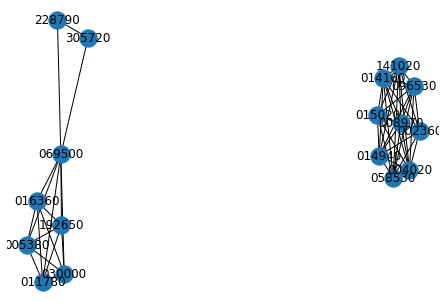

In [ ]:
g = nx.from_pandas_edgelist(a, 'source', 'target', create_using = nx.Graph())
nx.draw(g, with_labels=True)
# print(nx.info(g))
dgr = nx.degree_centrality(g)        # 연결 중심성
btw = nx.betweenness_centrality(g)   # 매개 중심성
cls = nx.closeness_centrality(g)     # 근접 중심성
egv = nx.eigenvector_centrality(g)   # 고유벡터 중심성
pgr = nx.pagerank(g)                 # 페이지 랭크

sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

G = nx.Graph()

for i in range(len(sorted_dgr)):
    G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1])

# for ind in range((len(np.where(dataset['freq'] > 20000)[0]))):
#     G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])

# 노드 크기 조정
sizes = [G.nodes[node]['nodesize'] * 500 for node in G]

options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}



In [ ]:


# plt.figure(figsize=(20, 20))
# pos = nx.spring_layout(g, k = 0.15)
# nx.draw_networkx(g,pos, node_size = 25, node_color = 'blue')
# plt.show()